In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import shap
# inspired by # https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html

In [3]:
num_classes = 100

model = models.resnet18(pretrained=False)

model.fc = nn.Linear(model.fc.in_features, num_classes)

model.load_state_dict(torch.load('resnet18_9.pth'))
# Step 3: Set the model to evaluation mode (important for inference)
model.eval()
print('done')

done


<ipython-input-3-8056422aaaf5>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18_9.pth'))


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print("done")

done


In [5]:
class_names = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl',
               'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar',
               'cattle', 'chair', 'chimpanzee',
               'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
               'dolphin', 'elephant', 'flatfish',
               'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp',
               'lawn_mower', 'leopard', 'lion', 'lizard',
               'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom',
               'oak_tree', 'orange', 'orchid', 'otter',
               'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate',
               'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon',
               'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk',
               'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
               'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television',
               'tiger', 'tractor', 'train', 'trout',
               'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [6]:
transform1 = transforms.Compose([
    transforms.Resize((224, 224)),  # Rescale for ResNet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

In [7]:
torch.manual_seed(42)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform1)

100%|██████████| 169M/169M [00:01<00:00, 105MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [11]:
no_of_instances_train = 10000
no_of_instances_test = 300

x_test = []
y_test = []


for it in range(no_of_instances_test):
  x_test.append(np.array(testset[it][0]).transpose(1, 2, 0))
  y_test.append(np.array(testset[it][1]))

x_test = np.array(x_test, copy=False)
y_test = np.array(y_test, copy=False)

print(y_test.shape)
print(x_test.shape)

(300,)
(300, 224, 224, 3)


In [8]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x



transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    #torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    #torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [14]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output

In [15]:
Xtr = transform(torch.Tensor(x_test))

In [16]:
# START FROM HERE
# pick an index to select an image from test set
# THIS IS FOR SINGLE IMAGE
pick_img_index = 30

In [17]:
out = predict(Xtr[pick_img_index:pick_img_index + 1])
classes = torch.argmax(out, axis=1).cpu().numpy()
print(f"Classes: {classes}: {np.array(class_names)[classes]}")

Classes: [20]: ['chair']


In [18]:
obtained_class_idx = classes[0]
print(obtained_class_idx)

20


In [19]:
topk = 4
batch_size = 50
n_evals = 1000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    Xtr[pick_img_index:pick_img_index + 1],
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:23, 83.32s/it]               


In [20]:
(shap_values.data.shape, shap_values.values.shape)

(torch.Size([1, 224, 224, 3]), (1, 224, 224, 3, 4))

In [21]:
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

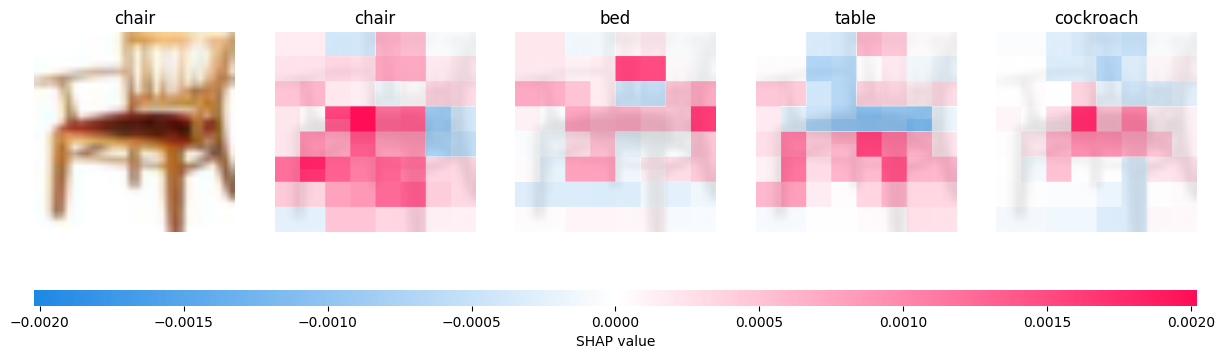

In [22]:
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[class_names[obtained_class_idx]],
)

In [ ]:
# NOW FOR MULTIPLE IMAGES AT ONCE

In [24]:
# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)


In [35]:
topk = 4
batch_size = 50
n_evals = 5000

start_idx = 30
samples_to_eval = 4

# feed only one image
shap_values = explainer(
    Xtr[start_idx:start_idx + samples_to_eval],
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 3/4 [11:52<02:55, 175.43s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [17:44<00:00, 249.07s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [23:29, 352.29s/it]


In [36]:
(shap_values.data.shape, shap_values.values.shape)

(torch.Size([4, 224, 224, 3]), (4, 224, 224, 3, 4))

In [37]:
shap_values.data = inv_transform(shap_values.data).cpu().numpy()
shap_values.values = [val for val in np.moveaxis(shap_values.values, -1, 0)]

In [38]:
(shap_values.data.shape, shap_values.values[0].shape)

((4, 224, 224, 3), (4, 224, 224, 3))

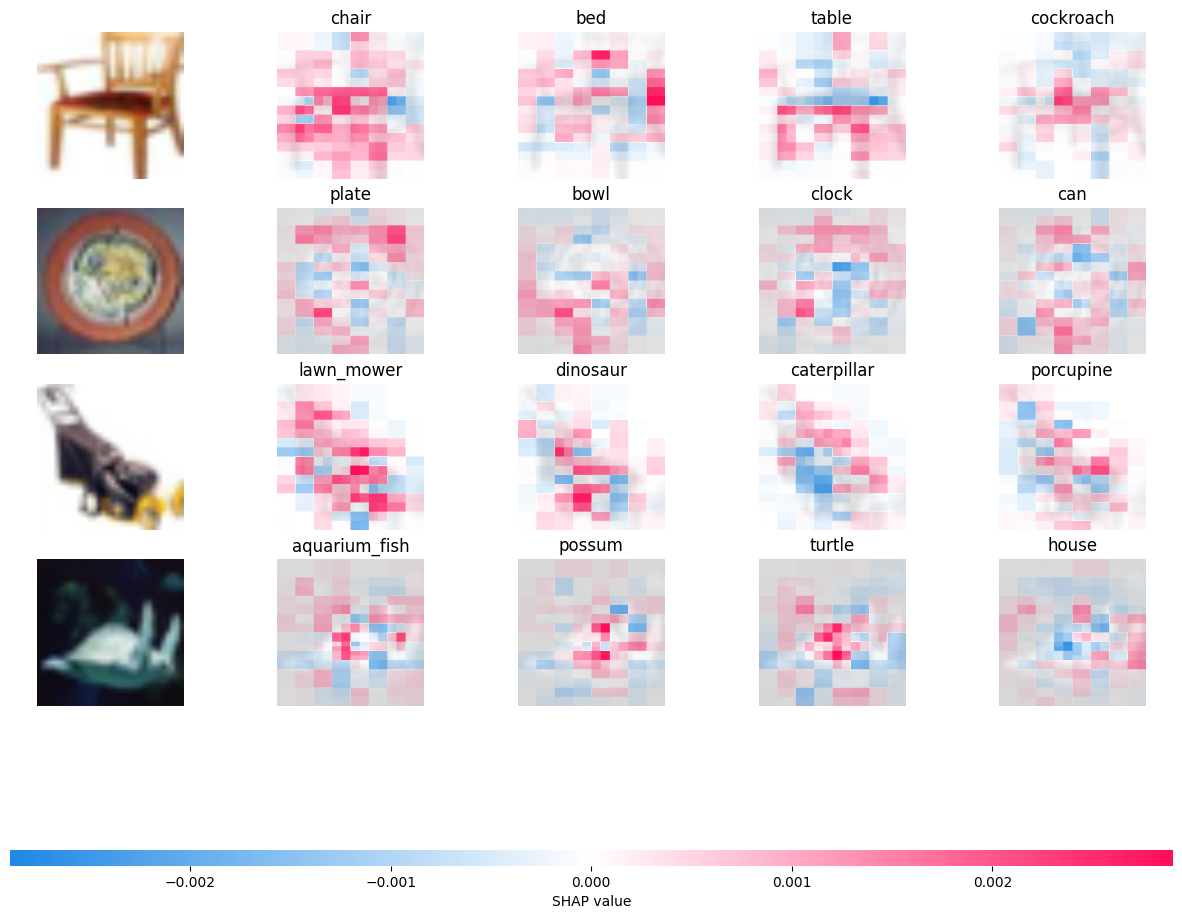

In [39]:
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
)